In [1]:
# read data

import pandas as pd

add_100 = pd.read_csv('data/addresses-with-balance-≥-100-btc-24h.csv')
add_100['timestamp'] = add_100['timestamp'].str.split('T', expand=True)[0]
add_100.set_index('timestamp', inplace=True)
add_100.columns = ['≥0.1k']

add_1k = pd.read_csv('data/addresses-with-balance-≥-1-k-btc-24h.csv')
add_1k['timestamp'] = add_1k['timestamp'].str.split('T', expand=True)[0]
add_1k.set_index('timestamp', inplace=True)
add_1k.columns = ['≥1k']

add_10k = pd.read_csv('data/addresses-with-balance-≥-10-k-btc-24h.csv')
add_10k['timestamp'] = add_10k['timestamp'].str.split('T', expand=True)[0]
add_10k.set_index('timestamp', inplace=True)
add_10k.columns = ['≥10k']

data = add_100.join(add_1k, on='timestamp').join(add_10k, on='timestamp')


In [2]:
# define fit function: log, exponent, power

def func1(x, a, b):
    return a * np.log(x) + b


def func2(x, a, b, c):
    return a * np.exp(-b * x) + c


def func3(x, a, b, c):
    return a * (x ** b) + c


In [3]:
# Use log function to fit

from scipy.optimize import leastsq
import numpy as np

res1 = pd.DataFrame(columns=('a', 'b', 'c', 'R^2'))
# res2 = pd.DataFrame(columns=('a', 'b', 'c', 'R^2'))
flag = 0
for i in range(len(data)):
    y = data.iloc[i].to_list()

    def func(i):
        a, b, c = i[0], i[1], i[2]

        return [
            a * np.exp(b * 100) + c - y[0],
            a * np.exp(b * 1000) + c - y[1],
            a * np.exp(b * 10000) + c - y[2]
        ]

    coef = leastsq(func, [0, 0, 0])[0].tolist()
    y_pre = [i + j for i, j in zip(func(coef), y)]
    y_bar = np.sum(y) / len(y)
    ssreg = np.sum((y_pre - y_bar) ** 2)
    sstot = np.sum((y - y_bar) ** 2)

    new = pd.DataFrame({'a': coef[0],
                        'b': coef[1],
                        'c': coef[2],
                        'R^2': ssreg / sstot},
                       index=[0])

    res1 = res1.append(new)

res1.index = data.index


C:\Users\zwlie\anaconda3\envs\weather\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\zwlie\anaconda3\envs\weather\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


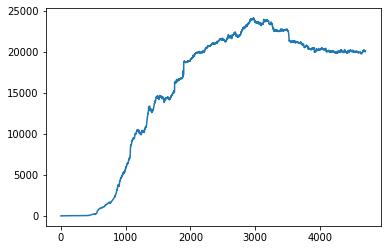

In [4]:
# plot of coef: a

import matplotlib.pyplot as plt

plt.plot(list(range(len(res1['a']))), res1['a'].to_list())
plt.show()


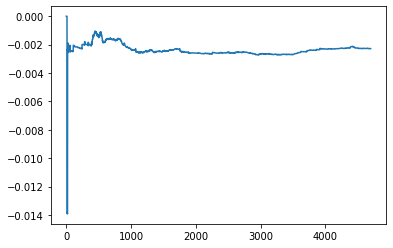

In [5]:
# plot of coef: b

plt.plot(list(range(len(res1['b']))), res1['b'].to_list())
plt.show()


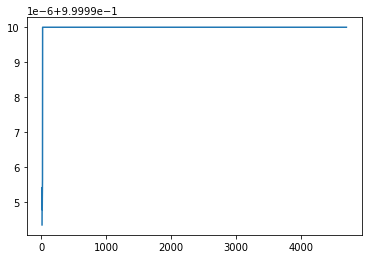

In [6]:
# plot of coef: R^2

plt.plot(list(range(len(res1['R^2']))), res1['R^2'].to_list())
plt.show()


In [43]:
# function to estimate quantity held by whales
from scipy.integrate import quad

def quantity_whale(threshold, coef):
    def func(x, new_coef):
        return -coef[0] * coef[1] * np.exp(new_coef[1] * x) * x

    return quad(func, threshold, np.inf, args=(coef))[0]


In [44]:

date = '2021-11-17'
coef = [res1.loc[date][0], res1.loc[date][1], res1.loc[date][2]]
q = quantity_whale(500, coef)
print(q)


6042548.20088797


In [45]:
date = '2021-11-17'
coef = [res1.loc[date][0], res1.loc[date][1], res1.loc[date][2]]
q = quantity_whale(300, coef)
print(q)


7498506.762927069


In [48]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_whale_change(data, threshold, days1, days2):
    dates = data.index.to_list()
    wh = [quantity_whale(threshold,[res1.loc[d][0], res1.loc[d][1], res1.loc[d][2]]) for d in dates]
    wh_change = [np.mean(wh[i - (days1 - 1):i + 1]) - np.mean(wh[i - (days2 - 1):i + 1]) for i in range(days2 - 1, len(wh))]
    whales = pd.DataFrame(columns=['date', 'whales_change', 'whales'])
    whales['date'] = dates[days2 - 1:]
    whales['whales_change'] = wh_change
    whales['whales'] = wh[days2 - 1:]

    btc_usdt = pd.read_csv("C:/Users/zwlie/PycharmProjects/pythonProject/data/price-btc-24h.csv")
    btc_usdt = btc_usdt.sort_values(by="timestamp")
    btc_usdt["price"] = btc_usdt["value"]
    btc_usdt['date'] = btc_usdt['timestamp'].str.split('T', expand=True)[0]
    btc_usdt = btc_usdt[['date', 'price']]

    whales = whales[whales['date'] >= '2020-01-01']
    btc_usdt = btc_usdt[btc_usdt['date'] <= '2021-11-17']
    btc_usdt = btc_usdt[btc_usdt['date'] >= '2020-01-01']
    
    trace0 = go.Scatter(x=whales['date'], y=whales['whales_change'], name='whales_change')
    trace1 = go.Scatter(x=whales['date'], y=whales['whales'], name='whales')
    trace2 = go.Scatter(x=btc_usdt['date'], y=btc_usdt['price'], name='price')

    fig = make_subplots(rows=3, cols=1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace0, 2, 1)
    fig.append_trace(trace1, 3, 1)
    fig.show()



In [51]:
plot_whale_change(data, 1000, 7 ,30)

In [40]:
plot_whale_change(data, 1000, 14 ,28)

In [41]:
plot_whale_change(data, 200, 15 ,30)

`Whale` is a cryptocurrency term that refers to individuals or entities hold a large amount of bitcoin. Since the number of bitcoin held by whales is large enough, they are considered to have the potential to manipulate currency valuations to a certain extent. As we have data recording the number of addresses holding more than 100, 1000, 10000 bitcoin, we try to fit a model indicating the number of bitcoin which belongs to whales. In this way, we can easily found whether whales tend to short or long bitcoitn in a period of time. We believe that such tendency stands a good chance of revealing future valule of bitcoin in a short term. 

